# NHL Salary Analysis

### Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=600):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Reading data

In [3]:
df = pd.read_csv('nhl_data.csv')
df.head()

,Name,Salary,Tm,Pos,GP,gf_60,ga_60,avg_shift,even_toi_sec,pp_toi_sec,sh_toi_sec
0,Nathan MacKinnon,16500000,COL,C,82,10.6,11.5,58,1094,270,3
1,Dougie Hamilton,12600000,NJD,D,20,16.0,0.0,46,1143,100,13
2,Alex Ovechkin,12500000,WSH,LW,79,7.8,0.0,51,879,273,0
3,Kirill Kaprizov,12500000,MIN,LW,75,9.8,0.0,59,1042,249,2
4,Seth Jones,12500000,CHI,D,67,6.7,7.8,55,1206,191,131


In [4]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Salary,GP,gf_60,ga_60,avg_shift,even_toi_sec,pp_toi_sec,sh_toi_sec
count,641.00,641.00,633.00,616.00,641.00,641.00,641.00,641.00
mean,3267715.12,62.95,5.29,7.14,43.28,834.38,78.60,61.73
std,3102593.00,21.43,5.06,14.93,7.78,177.04,74.70,57.78
min,8116.00,1.00,0.00,0.00,25.00,380.00,0.00,0.00
25%,800000.00,52.00,0.00,0.00,38.00,712.00,5.00,3.00
50%,2000000.00,72.00,5.30,6.30,43.00,832.00,58.00,52.00
75%,5200000.00,80.00,8.30,8.90,48.00,950.00,141.00,109.00
max,16500000.00,83.00,50.70,300.00,74.00,1312.00,275.00,225.00


Missing values in 'gf_60' and 'ga_60'

In [5]:
# Columns with missing values
columns_with_missing = df.columns[df.isna().any()]
print(columns_with_missing)

Index(['gf_60', 'ga_60'], dtype='object')


### Visualization

#### Heatmap
Decently high cor between Salary and pp toi

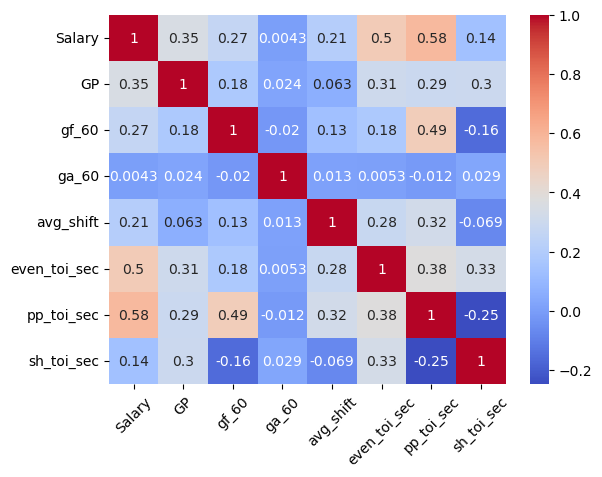

In [6]:
import seaborn as sns
corr = df.select_dtypes((int, float)).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.xticks(rotation = 45)
plt.show()

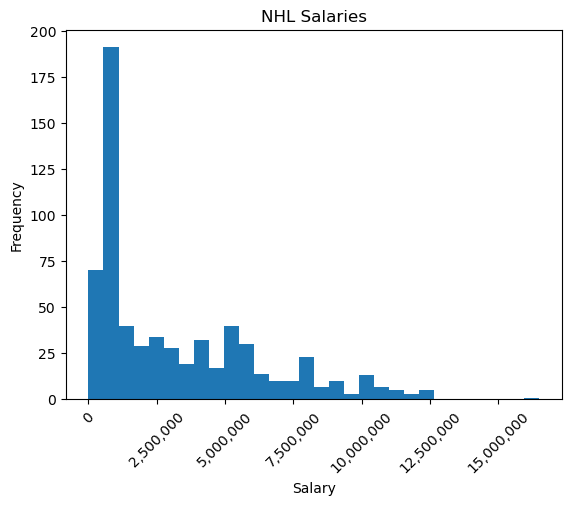

In [7]:
from matplotlib.ticker import FuncFormatter

def format_func(x, _):
    return f'{int(x):,}'  

plt.hist(df['Salary'], bins=30)
plt.title('NHL Salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency')

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.xticks(rotation = 45)
plt.show()


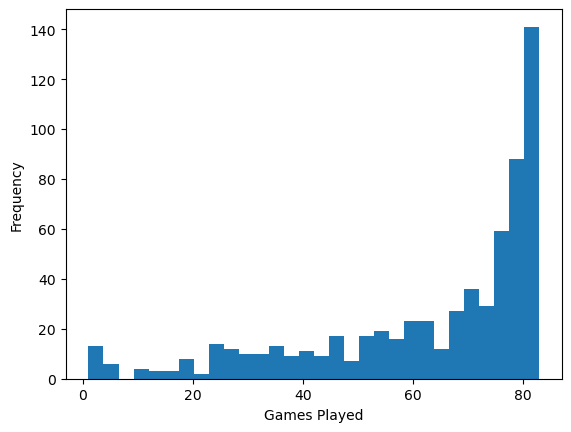

In [8]:
plt.hist(df['GP'], bins=30)
plt.xlabel('Games Played')
plt.ylabel('Frequency')
plt.show()

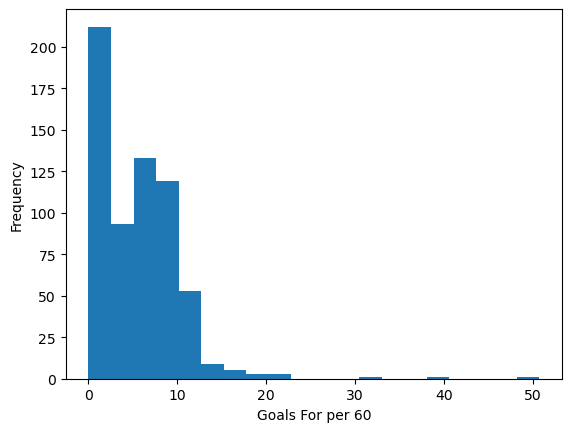

In [9]:
plt.hist(df['gf_60'], bins=20)
plt.xlabel('Goals For per 60')
plt.ylabel('Frequency')
plt.show()

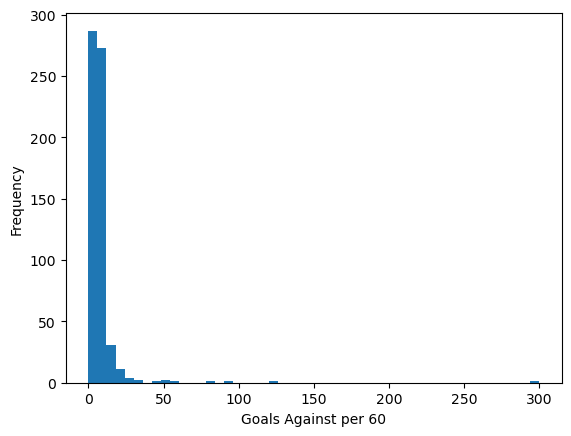

In [10]:
plt.hist(df['ga_60'], bins=50)
plt.xlabel('Goals Against per 60')
plt.ylabel('Frequency')
plt.show()

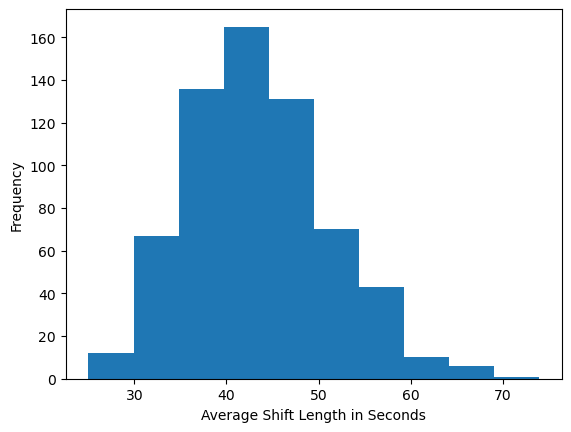

In [11]:
plt.hist(df['avg_shift'])
plt.xlabel('Average Shift Length in Seconds')
plt.ylabel('Frequency')
plt.show()

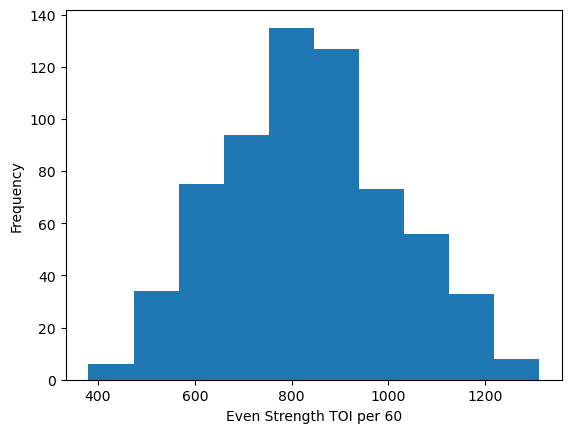

In [12]:
plt.hist(df['even_toi_sec'])
plt.xlabel('Even Strength TOI per 60')
plt.ylabel('Frequency')
plt.show()

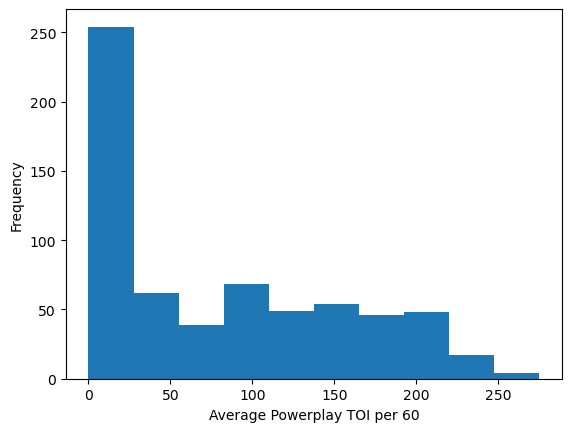

In [13]:
plt.hist(df['pp_toi_sec'])
plt.xlabel('Average Powerplay TOI per 60')
plt.ylabel('Frequency')
plt.show()

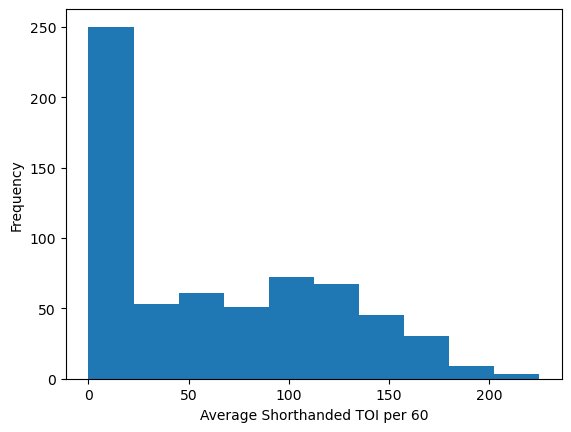

In [14]:
plt.hist(df['sh_toi_sec'])
plt.xlabel('Average Shorthanded TOI per 60')
plt.ylabel('Frequency')
plt.show()

### Preprocessing

Cleaning

In [15]:
df['Pos'] = df['Pos'].apply(
    lambda x: 'C' if x in ['C/LW', 'C/RW', 'C/W'] else
              'D' if x == 'D/RW' else
              'W' if x in ['LW', 'LW/C', 'LW/RW', 'RW', 'RW/C', 'F'] else
              x
)

df['Pos'].value_counts()

df = df.drop(columns=['Name', 'Tm'])

Imputing

In [16]:
# imputing by median due to skewness in variables with missing values
median_ga = df['ga_60'].median()
median_gf = df['gf_60'].median()

df['ga_60'] = df['ga_60'].fillna(median_ga)
df['gf_60'] = df['gf_60'].fillna(median_gf)

missing_values = df[['ga_60', 'gf_60']].isnull().sum()
print("Median ga_60: ", median_ga)
print("Median gf_60: ", median_gf)
print(missing_values)

Median ga_60:  6.3
Median gf_60:  5.3
ga_60    0
gf_60    0
dtype: int64


Splitting

In [17]:
# Partitioning
from sklearn.model_selection import train_test_split

X = df.drop(columns='Salary')
y = df['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training dataset:", X_train.shape)
print("Testing dataset:", X_test.shape)

Training dataset: (448, 8)
Testing dataset: (193, 8)


Transformations

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = ['Pos']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Transforming
scaler = StandardScaler()
X_train_xf = scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train_xf = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

y_test_xf = y_scaler.transform(y_test.values.reshape(-1, 1))

### Linear Regression

Better peformance on non transformed data
Negative correlation on transformed data. 

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

mdl = LinearRegression()
mdl.fit(X_train, y_train)

y_pred = mdl.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("mse: ", mse)

r2 = r2_score(y_test, y_pred)
print("r2: ", r2)


mse:  5163518033565.04
r2:  0.47361900901643506


### Random Forest

Non transformed data: 

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rf)
print("mse: ", mse)

r2 = r2_score(y_test, y_pred_rf)
print("r2: ", r2)

mse:  5158460498139.699
r2:  0.47413458589479973


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [500, 750, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Params: ", grid_search.best_params_)

rf = grid_search.best_estimator_
y_pred_rf = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rf)
print("mse: ", mse)

r2 = r2_score(y_test, y_pred_rf)
print("r2: ", r2)


Best Params:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}
mse:  5162846241750.522
r2:  0.4736874930303887


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the training data into training and validation sets
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define a set of hyperparameters to test
param_grid = [
    {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'},
    {'n_estimators': 750, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'},
    {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None},
]

# Loop over each set of hyperparameters
best_model = None
best_r2 = float('-inf')

for params in param_grid:
    rf = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        random_state=42
    )
    
    # Train the model on the training subset
    rf.fit(X_train_part, y_train_part)
    
    # Evaluate the model on the validation set
    y_val_pred = rf.predict(X_val)
    val_r2 = r2_score(y_val, y_val_pred)
    print(f"Params: {params}, Validation R2: {val_r2}")
    
    # Keep track of the best model
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_model = rf

# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Best Validation R2:", best_r2)
print("Test MSE:", mse)
print("Test R2:", r2)
